หากต้องการใช้ไลบรารีสนับสนุน mlxtend (https://github.com/rasbt/mlxtend) 
สำหรับพล็อตเส้นแสดงเขตการจำแนก สามารถติดตั้งไลบรารีโดยรันเซลล์ด้านล่าง

In [ ]:
#!pip install mlxtend

นำเข้าไลบรารีทั้งหมดที่ใช้งาน

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
import sklearn
import sklearn.datasets
from mlxtend.plotting import plot_decision_regions

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

พื่อความสะดวกจะสร้างฟังก์ชันสำหรับพล็อตความแม่นยำและค่าสูญเสีย โดยสามารถเรียกใช้ในตัวอย่างอื่นที่จะนำเสนอต่อไป

In [3]:
def plot_acc_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');


## 3.4 ขั้นตอนวิธีหาค่าเหมาะที่สุด

ตั้งแต่บทที่ 2 เราได้อธิบายวิธีลดค่าเกรเดียนต์ ซึ่งเป็นวิธีการพื้นฐานในการปรับค่าน้ำหนักในทิศทางเข้าสู่ค่าต่ำสุดของฟังก์ชันมูลค่า 
ในเวลาต่อมาได้มีการนำเสนอขั้นตอนวิธีที่ปรับปรุงให้ทำงานดีขึ้น รวมถึงการจัดข้อมูลเป็นกลุ่มเพื่อลดเวลาการฝึก 
ในหัวข้อนี้จะกล่าวถึงขั้นตอนวิธีหาค่าเหมาะที่สุดประเภทต่างๆ ที่สามารถเลือกได้จากไลบรารี TF และการฝึกโดยแบ่งกลุ่มข้อมูล

### 3.4.1 การแบ่งข้อมูลเป็นกลุ่มย่อย

งานด้านการเรียนรู้เชิงลึกมักเกี่ยวข้องกับชุดข้อมูลขนาดใหญ่ เป็นผลทำให้ต้องฝึกโมเดลเป็นเวลานานมากเมื่อใช้ขั้นตอนวิธีลดค่าเกรเดียนต์มาตรฐาน 
ถึงแม้ว่าการคำนวณเชิงเวกเตอร์จะช่วยลดเวลาในการประมวลผลลงได้ แต่สำหรับกรณีที่ตัวอย่างข้อมูลมีจำนวนมาก เช่น แปดล้านตัวอย่าง 
เราจะต้องประมวลผลสิบล้านตัวอย่างข้อมูลก่อนที่จะคำนวณหนึ่งขั้นของการลดค่าเกรเดียนต์ 

เราสามารถลดเวลาฝึกโมเดลได้โดยแบ่งข้อมูลทั้งหมดเป็นกลุ่มย่อย เรียกว่ากลุ่มเล็ก (mini-batch) 
ซึ่งอาจเป็นจำนวนเท่าไรก็ได้ขึ้นกับว่าชุดข้อมูลทั้งหมดมีมากน้อยเพียงใด ในทางปฏิบัตินิยมเลือกจำนวนเป็นค่ายกกำลังของฐานสอง 
แต่เพื่อความเข้าใจง่ายจะยกตัวอย่างว่าเลือกจำนวนข้อมูลในกลุ่มเล็กหนึ่งเท่ากับ 2,000 ตัวอย่าง
ดังนั้นข้อมูลทั้งหมด 8,000,000 ตัวอย่างจะถูกแบ่งได้เป็น 4,000 กลุ่มเล็ก 
สัญกรณ์ที่จะใช้แสดงหมายเลขกลุ่มคือเลขยกกำลังภายในวงเล็บปีกกา 
เช่นกลุ่มเล็กของอินพุต $X^{\{1\}},X^{\{2\}}, \ldots, X^{\{4000\}}$ และเลเบล $ํY^{\{1\}},Y^{\{2\}}, \ldots, Y^{\{4000\}}$

**หมายเหตุ :** ต้องไม่สับสนกับสัญกรณ์เลขยกกำลังในวงเล็บประเภทอื่นที่ใช้ก่อนหน้านี้ คือ $x^{(i)} $ แทนอินพุตตัวอย่างที่ $i$ 
 และ $a^{[l]}$ แทนเอาต์พุตของชั้นที่ $l$

โดยวิธีการแบ่งกลุ่มข้อมูลนี้ ขั้นตอนวิธีลดค่าเกรเดียนต์ปกติอาจถูกเรียกเต็มว่า การลดค่าเกรเดียนต์แบบกลุ่ม (batch) ซึ่งหมายถึงกลุ่มข้อมูลทั้งชุด 
ส่วนกรณีสุดทางอีกด้านหนึ่งคือเลือกขนาดข้อมูลในกลุ่มเล็กเท่ากับหนึ่งถูกเรียกว่า การลดค่าเกรเดียนต์แบบสโทแคสติก (stochastic) 
รูปที่ 3.21 เปรียบเทียบขั้นการลดค่าเกรเดียนต์ระหว่างกรณีทั้งสอง 
จะเห็นว่าวิธีแบบกลุ่มทางด้านซ้ายมีทิศทางในการลดค่าเกรเดียนต์ลงอย่างต่อเนื่อง (เมื่อเลือกขนาดของขั้นไม่ใหญ่เกินไป) แต่จะใช้เวลานาน
ส่วนวิธีแบบสโทแคสติกที่ใช้เวลาน้อยกว่าจะมีการแกว่งของทิศทางค่อนข้างมากแม้จะมีแนวโน้มสู่ค่าต่ำสุด 
และเมื่อเวลาผ่านไปจะไม่เข้าสู่ค่าต่ำสุดอย่างสมบูรณ์แต่จะวนเวียนอยู่โดยรอบ ในทางปฏิบัติมักเลือกทางสายกลาง คือแบ่งข้อมูลเป็นกลุ่มเล็กมากกว่า 
1 แต่ไม่เท่ากับกลุ่มข้อมูลทั้งหมด (เว้นแต่ว่าชุดข้อมูลทั้งหมดมีขนาดไม่ใหญ่มาก) 
อีกเหตุผลหนึ่งที่ไม่ควรเลือกวิธีสโทแคสติกคือเราจะเสียสมรรถนะการคำนวณเชิงเวกเตอร์ไป เพราะในหนึ่งลูปจะประมวลผลข้อมูลเพียงตัวอย่างเดียว

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1WPIif-YhJ9zvYvcQikL23YT2wStK41Nk" width=550 />
</p>
<div align="center">รูปที่ 3.21 เปรียบเทียบการลดค่าเกรเดียนต์ระหว่างวิธีแบบกลุ่มกับวิธีสโทแคสติก</div>

ไลบรารี TF สนับสนุนการแบ่งกลุ่มข้อมูลโดยมีตัวเลือก batch_size ที่กำหนดได้ใน model.fit() หากไม่มีการกำหนดจะใช้ค่าโดยปริยาย 
คือ 32 ถ้าต้องการให้กลุ่มเท่ากับข้อมูลทั้งชุดให้กำหนด batch_size = None 
เนื่องจากตัวอย่างในบทนี้ใช้ข้อมูลขนาดเล็กจึงไม่เห็นผลที่ชัดเจนจากการแบ่งกลุ่มข้อมูล

### 3.4.2 วิธีโมเมนตัม

จากหัวข้อย่อยที่ผ่านมาจะเห็นว่าผลจากการแบ่งข้อมูลฝึกเป็นกลุ่มเล็กทำให้แต่ละขั้นของการลดค่าเกรเดียนต์มีการแกว่งมากขึ้น 
สร้างปัญหาให้กับการเลือกอัตราการเรียนรู้ที่เหมาะสม เพราะหากขั้นใหญ่เกินไปอาจทำให้ขั้นตอนวิธีไม่ลู่เข้าสู่ค่าเหมาะที่สุด 
หรือหากเล็กเกินไปก็จะใช้เวลานานหรือติดอยู่ที่ค่าต่ำสุดเฉพาะที่ (local minimum)

เพื่อความเข้าใจจะยกตัวอย่างที่ทำให้ง่ายขึ้นดังรูปที่ 3.22 โดยสมมุติว่าพารามิเตอร์อยู่ในระนาบ 2 มิติและมีค่าต่ำสุดที่ศูนย์กลางของคอนทัวร์ 
ลูกศรแสดงค่าของพารามิเตอร์ที่ถูกปรับในแต่ละขั้น สังเกตได้ว่าค่ามีการแกว่งค่อนข้างมากในแกนที่ตั้งฉากกับแนวโน้มเข้าสู่คำต่ำสุด 
แนวคิดคือต้องการใช้อัตราการเรียนรู้ที่แตกต่างกันสำหรับแต่ละแกน โดยใช้อัตราที่สูงกว่าทิศทางที่มีแนวโน้มเข้าสู่ค่าต่ำสุดอย่างสม่ำเสมอ

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1UlHqITFRCcqTUkTaZ-A4xGPdpHNwnXRb" width=450 />
</p>
<div align="center">รูปที่ 3.22 อัตราการเรียนรู้สำหรับการลดค่าเกรเดียนต์</div>

วิธีการปรับปรุงตัวหาค่าเหมาะที่สุดโดยลดผลกระทบจากการแกว่งของพารามิเตอร์อาศัยหลักการของค่าเฉลี่ยที่ให้น้ำหนักแบบเลขชี้กำลัง 
(exponentially weighted averages) เรียกโดยย่อว่า EWA ที่รวมรายละเอียดไว้ในภาคผนวก A 
วิธีแรกที่จะกล่าวถึงคือการเพิ่มโมเมนตัม (momentum)ให้กับการลดค่าเกรเดียนต์ ต่อไปจะเรียกว่าวิธีโมเมนตัมเพื่อความกระชับ 
โดยทั่วไปแล้ววิธีโมเมนตัมสามารถทำงานเร็วกว่าการลดค่าเกรเดียนต์แบบปกติ ช่วยลดเวลาในการฝึกโมเดลลงได้

จากตัวอย่างในรูปที่ 3.22 การแกว่งในทิศทางของแกนที่ตั้งฉากกับแนวโน้มสู่ค่าต่ำสุดทำให้เราไม่สามารถใช้อัตราการเรียนรู้ที่เร็วได้ 
เพราะอาจทำให้ขั้นตอนวิธีไม่เสถียร ดังนั้นจึงต้องการกรองการรบกวนนี้โดย EWA ขั้นตอนวิธีโมเมนตัมมีเค้าโครงดังนี้

* กำหนดตัวแปร $V_{dW}, V_{db}$ ที่จะใช้ปรับค่าพารามิเตอร์ $W, b$ ในแต่ละขั้น โดยตั้งค่าเริ่มต้นเป็นศูนย์

ในการวนรอบที่ $k$:
* คำนวณค่า $dW, db$ สำหรับข้อมูลกลุ่มย่อยขณะนั้น
* คำนวณการเปลี่ยนแปลงของตัวแปร $V_{dW}, V_{db}$
$$
V_{dW} = \beta_1 V_{dW} + (1 - \beta_1)dW \tag{3.13}
$$
$$
V_{db} = \beta_1 V_{db} + (1 - \beta_1)db \tag{3.14}
$$
* ปรับค่าพารามิเตอร์โดยใช้ $V_{dW}, V_{db}$ แทนค่าที่เปลี่ยนแปลงในแต่ละขั้น
$$
W := W - \alpha V_{dW} \tag{3.15}
$$
$$
b := b - \alpha V_{db} \tag{3.16}
$$

โดย $\beta_1$ คือค่าไฮเปอร์พารามิเตอร์ใหม่สำหรับวิธีโมเมนตัม ทำหน้าที่เหมือนกับ $\beta$ ในภาคผนวก A 
แต่เหตุผลที่ใช้ตัวห้อย 1 เพื่อมิให้สับสนกับไฮเปอร์พารามิเตอร์ตัวอื่นที่เพิ่มขึ้นเมื่อขยายไปยังวิธีการอื่นที่จะกล่าวถึงต่อไป
ผลของการปรับพารามิเตอร์โดยวิธีโมเมนตัมคือทำให้การแกว่งลดลงจากการใช้ค่าเฉลี่ยแทนค่าของ $dW, db$ 

สำหรับผู้ที่มีความรู้ด้านฟิสิกส์สามารถเข้าใจหลักการของวิธีโมเมนตัมได้โดยเปรียบพจน์ $dW, db$ 
กับความเร่งของลูกบอลที่ไหลลงเนินสู่จุดต่ำสุด (หากมองรูปที่ 3.22 เป็นรูปชาม 3 มิติ) และพจน์โมเมนตัม $V_{dW}, V_{db}$
เปรียบได้กับความเร็วของลูกบอล ดังนั้น $\beta_1$ เปรียบได้กับแรงเสียดทานที่จะป้องกันมิให้ลูกบอลมีความเร็วเพิ่มขึ้นโดยไร้ขีดจำกัด 

สังเกตว่าไฮเปอร์พารามิเตอร์ของวิธีโมเมนตัมจะเพิ่มเป็น 2 ตัวคืออัตราการเรียนรู้ $\alpha$ และตัวควบคุม EWA คือ $\beta_1$ 
ค่าที่นิยมใช้คือ $\beta_1 = 0.9$ และสำหรับวิธีโมเมนตัมในทางปฎิบัติมักไม่มีการแก้ไขค่าเอนเอียง
เนื่องจากไม่มีผลกระทบมากนัก

บางครั้งเราอาจพบการอิมพลิเมนต์วิธีโมเมนตัมที่แตกต่างจาก (3.13)-(3.14) เล็กน้อย คือละทิ้งตัวประกอบ $(1-\beta_1)$ 
$$
V_{dW} = \beta_1 V_{dW} + dW \tag{3.17}
$$
$$
V_{db} = \beta_1 V_{db} + db \tag{3.18}
$$
โดยวิธีการนี้ค่าของ $\alpha$ จะต้องถูกชดเชยโดยค่า $(1-\beta_1)^{-1}$ ซึ่งอาจทำให้การปรับแต่งไฮเปอร์พารามิเตอร์ยุ่งยากขึ้น 

ในการเรียกใช้วิธีโมเมนตัมสำหรับไลบรารี TF จะมีตัวเลือก momentum ในตัวหาค่าเหมาะที่สุดแบบ SGD()
ซึ่งเมื่อกำหนดค่ามากกว่าศูนย์จะเพิ่มพจน์โมเมนตัมในการปรับค่า (โจทย์ปัญหา 3-6)

### 3.4.3 วิธีการแพร่กระจายแบบรากกำลังสองเฉลี่ย

ขั้นตอนวิธีการหาค่าเหมาะที่สุดอีกรูปแบบหนึ่งที่ทำให้การลดค่าเกรเดียนต์ทำงานเร็วขึ้นคือ วิธีการแพร่กระจายแบบรากกำลังสองเฉลี่ย
(root mean square propagation) นิยมเรียกย่อว่า RMSprop 

อ้างถึงรูปที่ 3.22 เพื่อความง่ายในการอธิบายจะสมมุติว่าค่าพารามิเตอร์ในทิศทางที่มีการแกว่งคือ $b$ 
และค่าที่มีแนวโน้มเข้าสู่ศูนย์กลางของคอนทัวร์อย่างสม่ำเสมอคือ $W$ (ในความเป็นจริงจะเป็นระบบหลายมิติที่ไม่สามารถบรรยายโดยภาพได้ 
ค่าพารามิเตอร์ที่แกว่งมาก/น้อยเป็นเซ็ตย่อยของพารามิเตอร์ทั้งหมด) ดังนั้้นความต้องการคือกำหนดอัตราการเรียนรู้ต่ำในทิศทางของ 
$b$ และอัตราสูงกว่าในทิศทางของ $W$ ขั้นตอนวิธี RMSprop มีเค้าโครงดังนี้

* กำหนดตัวแปร $S_{dW}, S_{db}$ ที่จะใช้ปรับค่าพารามิเตอร์ $W, b$ ในแต่ละขั้น โดยตั้งค่าเริ่มต้นเป็นศูนย์

ในการวนรอบที่ $k$:
* คำนวณค่า $dW, db$ สำหรับข้อมูลกลุ่มย่อยขณะนั้น
* คำนวณการเปลี่ยนแปลงของตัวแปร $S_{dW}, S_{db}$
$$
S_{dW} = \beta_2 S_{dW} + (1 - \beta_2)(dW)^2 \tag{3.19}
$$
$$
S_{db} = \beta_2 S_{db} + (1 - \beta_2)(db)^2 \tag{3.20}
$$
โดย $dW^2, db^2$ คือการยกกำลังสองสำหรับแต่ละสมาชิก (element-wise) และไฮเปอร์พารามิเตอร์สำหรับวิธี 
RMSprop คือ $\beta_2$ จะใช้ตัวห้อย 2 เพื่อให้แตกต่างจากที่ใช้ในวิธีโมเมนตัม 

* ปรับค่าพารามิเตอร์โดยใช้ $dW, db$ ที่ถูกปรับมาตราส่วนโดยรากกำลังสองของ $S_{dW}, S_{db}$ 
สำหรับค่า $\epsilon$ เป็นค่าน้อยเช่น $10^{-8}$ มีไว้เพื่อป้องกันปัญหาจากการหารด้วยศููนย์
$$
W := W - \alpha \frac{dW}{\sqrt{S_{dW}}+\epsilon} \tag{3.21}
$$
$$
b := b - \alpha \frac{db}{\sqrt{S_{db}}+\epsilon}  \tag{3.22}
$$

เมื่อดูเค้าโครงแล้วคงพอเข้าใจถึงเหตุผลที่เรียกวิธีการนี้ว่า "การแพร่กระจายแบบรากกำลังสองเฉลี่ย" จากข้อสมมุติก่อนหน้านี้ 
ในทิศทางของพารามิเตอร์ $b$ ที่มีการแกว่งมากกว่า $W$ ทำให้ค่ากำลังสองของความชัน $(db)^2$ 
จะมีค่าสูงกว่า $(dW)^2$ ส่งผลให้ $S_{db}$ มีค่าสูงกว่า $S_{dW}$ 
ดังนั้นอัตราการปรับค่าพารามิเตอร์ $b$ จะต่ำกว่าอัตราการปรับค่า $W$ เนื่องจากถูกหารด้วยพจน์ $\sqrt{S_{db}}$ 
ที่มีค่าสูงกว่า $\sqrt{S_{dW}}$ 

สรุปสำหรับกรณีทั่วไป ตัวหาค่าเหมาะที่สุดแบบ RMSprop จะปรับอัตราการเรียนรู้ของพารามิเตอร์ที่มีการแกว่ง (ความชันสูง) 
ให้น้อยกว่าอัตราของพารามิเตอร์ที่เรียบ (ความชันต่ำ) 
ซึ่งจะช่วยทำให้การลดค่าเกรเดียนต์ทำได้เร็วขึ้นโดยไม่เกิดการลู่ออกของพารามิเตอร์ที่มีการแกว่งมาก

ในไลบรารี TF มีตัวหาค่าเหมาะที่สุดแบบ rmsprop ให้เลือกใช้ โดยใน model.compile() กำหนด optimizer=RMSprop 
หรือสร้างออปเจ็กในบรรทัดต่างหากเพื่อกำหนดค่าอาร์กิวเมนต์ได้ 

### 3.4.4 วิธีการ Adam

Adam มิใช่ชื่อบุคคลหรือรัสพจน์แต่เป็นขั้นตอนวิธีหาค่าเหมาะที่สุดที่อนุพัทธ์จาก "adaptive moment estimation" 
เป็นเสมือนการต่อยอดจากวิธีโมเมนตัมและ RMSprop มีเค้าโครงเป็นดังนี้

* กำหนดตัวแปร $V_{dW}, V_{db}, S_{dW}, S_{db}$ ที่จะใช้ปรับค่าพารามิเตอร์ $W, b$ ในแต่ละขั้น โดยตั้งค่าเริ่มต้นเป็นศูนย์

ในการวนรอบที่ $k$:
* คำนวณค่า $dW, db$ สำหรับข้อมูลกลุ่มย่อยขณะนั้น
* คำนวณการเปลี่ยนแปลงของตัวแปร $V_{dW}, V_{db}, S_{dW}, S_{db}$
$$
V_{dW} = \beta_1 V_{dW} + (1 - \beta_1)dW \tag{3.33}
$$
$$
V_{db} = \beta_1 V_{db} + (1 - \beta_1)db \tag{3.34}
$$
$$
S_{dW} = \beta_2 S_{dW} + (1 - \beta_2)(dW)^2 \tag{3.35}
$$
$$
S_{db} = \beta_2 S_{db} + (1 - \beta_2)(db)^2 \tag{3.36}
$$
โดย $dW^2, db^2$ คือการยกกำลังสองสำหรับแต่ละสมาชิก (element-wise) และสำหรับวิธี Adam 
จะใช้การแก้ไขค่าเอนเอียงกับ $V_{dW}, V_{db}, S_{dW}, S_{db}$ แทนด้วยตัวแปร 
$V_{dWc}, V_{dbc},S_{dWc}, S_{dbc}$
$$
V_{dWc}= \frac{V_{dW}}{(1-\beta_1^k)} \tag{3.37}
$$
$$
V_{dbc} = \frac{V_{db}}{(1-\beta_1^k)} \tag{3.38}
$$
$$
S_{dWc} = \frac{S_{dW}}{(1-\beta_2^k)} \tag{3.39}
$$
$$
S_{dbc} = \frac{S_{db}}{(1-\beta_2^k)} \tag{3.40}
$$
* ปรับค่าพารามิเตอร์โดยใช้ $V_{dWc}, V_{dbc}$ 
ที่ถูกปรับมาตราส่วนโดยรากกำลังสองของ $S_{dWc}, S_{dbc}$ 
สำหรับค่า $\epsilon$ เป็นค่าน้อยเช่น $10^{-8}$ มีไว้เพื่อป้องกันปัญหาจากการหารด้วยศููนย์
$$
W := W - \alpha \frac{V_{dWc}}{\sqrt{S_{dWc}}+\epsilon} \tag{3.41}
$$
$$
b := b - \alpha \frac{V_{dbc}}{\sqrt{S_{dbc}}+\epsilon}  \tag{3.42}
$$

จะเห็นว่าวิธีการ Adam มีไฮเปอร์พารามิเตอร์หลายตัว ค่าที่แนะนำในเบื้องต้นคือ

* อัตราการเรียนรู้ $\alpha$ ต้องมีการปรับแต่ง
* ตั้งค่า $\beta_1 = 0.9$ 
* ตั้งค่า $\beta_2 = 0.999$ 
* กำหนด $\epsilon = 10^{-8}$ (ค่านี้ไม่มีผลมากนักกับสมรรถนะ)

**ตัวอย่าง 3.7**

ต้องการทดลองใช้ขั้นตอนวิธีหาค่าเหมาะที่สุด 3 แบบกับข้อมูลที่มีให้ในไลบรารี sklearn คือ moons 
เป็นการจำแนกทวิภาคจุดข้อมูลที่มีลักษณะเหมือนจันทร์เสี้ยว 2 ดวงคาบเกี่ยวกันดังเช่นในรูปที่ 3.23 เขียนฟังก์ชัน 
load_moons_dataset() และเรียกใช้เพื่อจัดรูปข้อมูลสำหรับฝึกและทดสอบ 

In [4]:
def load_moons_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_moons(n_samples=100, noise=.2) #100 #0.2 
    train_Y = train_Y[:,np.newaxis]
    test_Y = test_Y[:,np.newaxis]
    
    for i in range(len(train_Y)):
        if train_Y[i,0] == 1:
            plt.scatter(train_X[i,0],train_X[i,1],c='orange', marker='^',s=40)
        else:
            plt.scatter(train_X[i,0],train_X[i,1],c='blue', marker='s',s=40)    
    
    return train_X, train_Y, test_X, test_Y

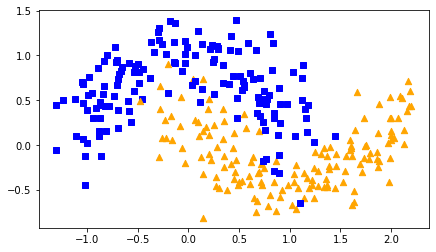

In [5]:
train_X, train_Y, test_X, test_Y = load_moons_dataset()

รูปที่ 3.23 ชุดข้อมูลสองประเภทที่เรียงตัวรูปจันทร์เสี้ยว 2 ดวง

สร้างโมเดล 3 ชั้นที่มีเซลล์แต่ละชั้นเท่ากับ 5,2,1 

In [6]:
model = Sequential([
    Flatten(input_shape=[2]),
    Dense(5,  activation='relu'),
    Dense(2,  activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

การกำหนดตัวหาค่าเหมาะที่สุดจะอยู่ในขั้้นตอนคอมไพล์ โดยจะเปรียบเทียบระหว่างวิธี SGD() ที่ตั้งค่า momentum=0.9 
วิธี RMSprop() และวิธี Adam() ใช้อัตราการเรียนรู้ 0.01 ผู้อ่านสามารถเลือกระหว่าง 3 คำสั่งในเซลล์นี้ 
โดยสามารถทดลองเพิ่มการกำหนดค่าไฮเปอร์พารามิเตอร์ได้ตามต้องการ 


In [7]:
# choose your optimizer
model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.9),loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=RMSprop(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

ผึกจำนวน 5000 รอบ โดยแบ่งข้อมูลฝึกเป็นกลุ่มเล็กขนาด 32 พล็อตค่าความแม่นยำและค่าสูญเสียจากการฝึก รวมถึงเส้นแบ่งอาณาเขตเปรียบเทียบกันได้ผลดังในรูปที่ 
3.24 พบว่ามีสมรรถนะใกล้เคียงกัน  

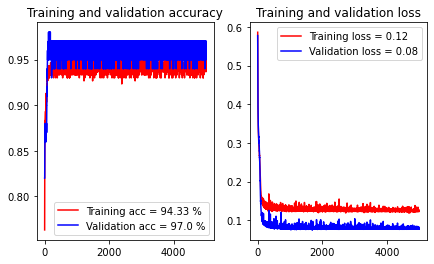

In [8]:
history = model.fit(train_X, train_Y, epochs=5000, batch_size=32,validation_data=(test_X,test_Y),verbose=0)
plot_acc_loss(history)

4536/4536 [==============================] - 4s 971us/step


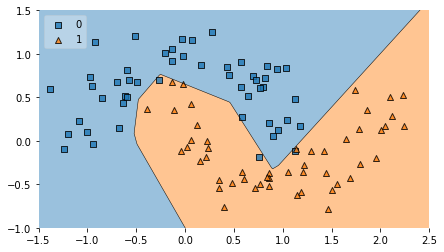

In [9]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model, legend=2)
plt.xlim([-1.5,2.5])
plt.ylim([-1.0,1.5])
plt.show()

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1zjvOGP62DQD2SDS_3Yf2torQ6sMF9OKA" width750 />
</p>
<div align="center">รูปที่ 3.24 เปรียบเทียบผลจากการใช้ตัวหาค่าเหมาะที่สุด 3 ประเภท</div>

### 3.4.5 การลดระดับอัตราการเรียนรู้

ในตัวอย่างที่ผ่านมาเราได้กำหนดอัตราการเรียนรู้เป็นค่าคงที่ตลอดการฝึก ข้อเสียคือเมื่อมีการแบ่งข้อมูลกลุ่มเล็กหรือใช้วิธีสโทแคสติก (รูปที่ 3.21) 
ค่าพารามิเตอร์ที่ถูกปรับแต่ละขั้นยังคงมีขนาดใหญ่แม้เข้าใกล้จุดต่ำสุด ดังนั้นเราสามารถปรับปรุงสมรรถนะของโมเดลได้โดยปรับค่าของอัตราเรียนรู้ให้มีค่าลดลงตามจำนวนรอบการฝึก
หลักการนี้เรียกว่า การลดระดับอัตราการเรียนรู้ (learning rate decay)

วิธีการพื้นฐานคือ ตั้งค่าอัตราการเรียนรู้ให้ขึ้นกับรอบของการประมวลผลข้อมูลทั้งชุด (ภาษาอังกฤษใช้คำว่า "epoch") 

$$
\alpha = \frac{1}{1+decay\_rate*epoch\_no}\alpha_0 \tag{3.43}
$$

โดย $\alpha_0$ คือค่าเริ่มต้นของอัตราการเรียนรู้ $decay\_rate$ คืออัตราการลดระดับ และ $epoch\_no$ คือหมายเลขของจำนวนรอบการฝึกเริ่มจาก 
$1,2,\ldots$ ตัวอย่างเช่นเมื่อกำหนด $\alpha_0 = 0.2, decay\_rate = 1$ 
ค่าอัตราการเรียนรู้เทียบกับจำนวนรอบจะมีค่า $0.1, 0.067, 0.05, 0.04, \ldots $

วิธีการอื่นที่มีการใช้งานกันคือการลดระดับเชิงเลขชี้กำลัง 

$$
\alpha = 0.95^{epoch\_no}\alpha_0 \tag{3.44}
$$

หรือในรูปตัวประกอบการลดระดับอื่นๆ เช่น

$$
\alpha = \frac{k}{\sqrt{epoch\_no}} \alpha_0 \tag{3.45}
$$

โดย $k$ คือค่าคงที่ การลดระดับอัตราการเรียนรู้อาจเป็นแบบไม่ต่อเนื่องก็ได้ สังเกตว่าใน (3.43)-(3.45) 
การลดระดับจะอยู่ในรูปสมการทางคณิตศาสตร์ อีกวิธีหนึ่งที่นิยมใช้คือการวัดค่าความแม่นยำหรือค่าสูญเสียระหว่างการฝึก 
เพื่อปรับค่าอัตราการเรียนรู้ให้เหมาะสม หากใช้ไลบรารี TF สามารถเขียนฟังก์ชันเรียกกลับเพื่อทำงานดังกล่าวได้ 

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>